## Required Imports

In [1]:
import h5py
import matplotlib.pyplot as plt
from dataclasses import dataclass
import numpy as np
import os
import json
import lmfit as lm

from common import save_to_igor_itx, calculate_fit, get_data_index, i_sense, mean_data


local_data_path = 'D:/Measurements/FebMar21/Experiment_Data'

## Data

In [2]:
datnums = list(range(7437, 7844+1))

@dataclass
class DataEntry:
    data2d: np.ndarray
    x: np.ndarray
    y: np.ndarray  # Generally will just be repeat number
    i_heat: float
    fridge_temp: float
    datnum: int
    data_avg: np.ndarray = None
    x_avg: np.ndarray = None


data_entries = list()
for num in datnums:
    with h5py.File(os.path.join(local_data_path, f'Dat{num}.h5'), 'r') as f:
        data = f['cscurrent_2d'][:]
        x = f['x_array'][:]
        y = f['y_array'][:]
        sweeplogs = json.loads(f['metadata'].attrs['sweep_logs'])

        i_heat = sweeplogs['FastDAC 1']['DAC6{HO1/10M}']/10  # Bias applied in mV through 10 Mohm resistor
        fridge_temp = sweeplogs['Lakeshore']['Temperature']['MC K']

    data_entries.append(DataEntry(data, x, y, i_heat, fridge_temp, num))




In [3]:
# for entry in data_entries:
#     print(f'{entry.datnum}:\n \t{entry.i_heat:.1f} nA\n\t{entry.fridge_temp*1000:.0f} mK')

In [4]:
def fit_restricted_width(x, data, params, func, start_x: float, end_x: float):
    indexes = get_data_index(x, [start_x, end_x], is_sorted=True)
    x = x[indexes[0]:indexes[1]]
    data = data[indexes[0]: indexes[1]]
    return calculate_fit(x, data, params, func)

In [7]:
width = 2500  # -2500 -> 2500 is full scan
params = lm.Parameters()
params.add_many(
    ('mid', 0, True, None, None, None, None),
    ('theta', 5, True, 0.01, None, None, None),
    ('amp', 1, True, 0, None, None, None),
    ('lin', 0.001, True, 0, None, None, None),
    ('const', 5, True, None, None, None, None)
)
for entry in data_entries:
    fits = [fit_restricted_width(entry.x, data_1d, params, i_sense, -width, width) for data_1d in entry.data2d]
    centers = [fit.params['mid'].value for fit in fits]
    avg_data, avg_x = mean_data(entry.x, entry.data2d, centers, return_x=True)
    entry.data_avg = avg_data
    entry.x_avg = avg_x

## T = 100mK Quadratic Fit

In [19]:
data_100mk = [entry for entry in data_entries if np.isclose(entry.fridge_temp*1000, 100, atol=5) and abs(entry.i_heat) < 3]

data_100mk = list(sorted(data_100mk, key=lambda e: e.i_heat))

width = 500
params = lm.Parameters()
params.add_many(
    ('mid', 0, True, None, None, None, None),
    ('theta', 5, True, 0.01, None, None, None),
    ('amp', 1, True, 0, None, None, None),
    ('lin', 0.001, True, 0, None, None, None),
    ('const', 5, True, None, None, None, None)
)

fits = [fit_restricted_width(e.x_avg, e.data_avg, params, i_sense, -width, width) for e in data_100mk]
thetas = np.array([fit.params['theta'].value for fit in fits])
biases = np.array([e.i_heat for e in data_100mk])

quad = lm.models.QuadraticModel()
quad_params = quad.guess(thetas, biases)
quad_fit = quad.fit(thetas, x=biases, params=quad_params)

## Quick plot before exporting data to Igor for final Figure

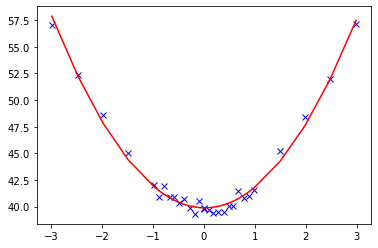

In [21]:
fig, ax = plt.subplots(1)
ax.plot(biases, thetas, 'bx')
ax.plot(biases, quad_fit.eval(x=biases), '-r')

## Save to .itx file for final Figure in Igor

In [22]:
save_to_igor_itx("exports/100mk thetas.itx", [biases, biases], [thetas, quad_fit.eval(x=biases)], ["theta100_data", "theta100_quad_fit"])

## Varying Fridge T data

In [23]:
def quad_heat_phonon_cool_func(x, R, a, b, Tph):
    return np.abs(np.sqrt((a/R**2)*(x**2 - Tph**2) + (b/R)*(x**5 - Tph**5)))

imodel = lm.Model(quad_heat_phonon_cool_func)
phonon_params = lm.Parameters()
phonon_params.add('R', value=1, min=0, max=10000, vary=True)
phonon_params.add('a', value=0.4, min=1e-7, max=100, vary=True)
phonon_params.add('b', value=10, min=0, max=100, vary=True)
phonon_params.add('Tph', value=0.09, min=0, max=200, vary=False)

transition_params = lm.Parameters()
transition_params.add_many(
    ('mid', 0, True, None, None, None, None),
    ('theta', 5, True, 0.01, None, None, None),
    ('amp', 1, True, 0, None, None, None),
    ('lin', 0.001, True, 0, None, None, None),
    ('const', 5, True, None, None, None, None)
)


In [27]:
temps = [50, 100, 200, 300, 400, 500]
width = 2500

results = {}
for temp in temps:
    datas = [entry for entry in data_entries if np.isclose(entry.fridge_temp*1000, temp, atol=10) and entry.i_heat >= 0]
    datas = list(sorted(datas, key=lambda entry: entry.i_heat))
    biases = np.array([e.i_heat for e in datas])
    transition_fits = [fit_restricted_width(e.x_avg, e.data_avg, transition_params, i_sense, -width, width) for e in datas]
    thetas = np.array([fit.params['theta'].value for fit in transition_fits])

    # phonon_fit = imodel.fit(biases, x=thetas, params=phonon_params)
    phonon_fit = None

    results[temp] = dict(biases = biases, thetas = thetas, fit = phonon_fit)

## Quick plot before exporting

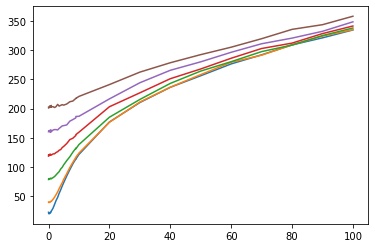

In [28]:
fig, ax = plt.subplots(1)
for temp, d in results.items():
    x = d['biases']
    ax.plot(x, d['thetas'], linestyle='-', label=temp)
    # ax.plot(x, d['fit'].eval(x=x), linestyle=':', label=f'{temp}_fit')



## Save to .itx file for final Figure in Igor

In [29]:
save_to_igor_itx("exports/all temp thetas.itx",
                 xs = [d['biases'] for d in results.values()],
                 datas = [d['thetas'] for d in results.values()],
                 names = [f'{k}mk all temps.itx' for k in results.keys()]
                 )